In [4]:
import pyFAI
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import fabio
import pyFAI.gui
import pyFAI.detectors
import pyFAI.calibrant
from pyFAI.gui import jupyter
import silx
import pygix
import math
import os

print("Using pyFAI version",pyFAI.version) #This should be version 21.3 (version 20.0 does not have jupyter integration

Using pyFAI version 0.21.3


<AxesSubplot:>

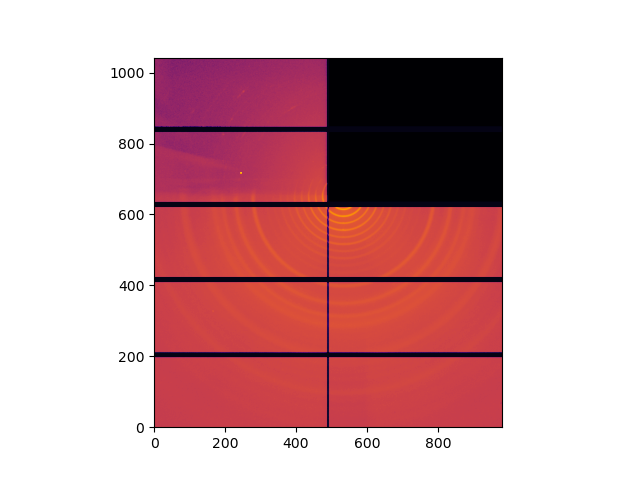

In [5]:
#iPython magic to make interactive plots work
%matplotlib widget
#Declare your path to calibration folder
calib_path ='/Users/Thomas2/Desktop/Keith_data/'
#Select calibration file
img = fabio.open(calib_path+'AgBh_GIWAXS_5000RPM_TopOn_780.2s_x0.249_th1.000_2.00s_632051_maxs.tiff').data
#pyFAI.gui command to display 2D detector image
jupyter.display(img)

"tiled_hi" calibration

In [44]:
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.gui.jupyter.calib import Calibration
#Declare your path to calibration folder
calib_path ='/Users/Thomas2/Desktop/Keith_data/'

#initialize parameters of the scan
wavelength = 0.9760e-10
pilatus = pyFAI.detector_factory('Pilatus1M')
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength=wavelength

#load calibration file
img = fabio.open(calib_path+'AgBh_GIWAXS_5000RPM_TopOn_780.2s_x0.249_th1.000_2.00s_632051_maxs.tiff').data
#jupyter.display(img,label = "AgBh")

x_cent = 533
y_cent = 652
sdd = 195
initial = pyFAI.geometry.Geometry(detector=pilatus, wavelength=wavelength)
initial.setFit2D(sdd,x_cent,y_cent)
initial

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 9.760000e-11m
SampleDetDist= 1.950000e-01m	PONI= 1.121440e-01, 9.167600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 195.000mm	Center: x=533.000, y=652.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [45]:
from pyFAI.goniometer import SingleGeometry
sg = SingleGeometry("demo", img, calibrant=AgBh, detector=pilatus, geometry=initial)
sg.extract_cp(max_rings=5)

ControlPoints instance containing 5 group of point:
AgBh Calibrant with 49 reflections at wavelength 9.76e-11
Containing 5 groups of points:
#ay ring 0: 0 points
#az ring 1: 10 points
#ba ring 2: 35 points
#bb ring 3: 64 points
#bc ring 4: 90 points

In [46]:
sg.geometry_refinement.refine3(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 9.760000e-11m
SampleDetDist= 2.008385e-01m	PONI= 1.123889e-01, 9.186078e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.839mm	Center: x=534.074, y=653.424 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [59]:
sg.geometry_refinement.refine3(fix=["wavelength"])
sg.get_ai()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 9.760000e-11m
SampleDetDist= 1.970345e-01m	PONI= 9.649802e-02, 6.224646e-02m	rot1=-0.148923  rot2= 0.079228  rot3= 0.000000 rad
DirectBeamDist= 199.867mm	Center: x=533.769, y=653.003 pix	Tilt=9.657 deg  tiltPlanRotation= 28.151 deg

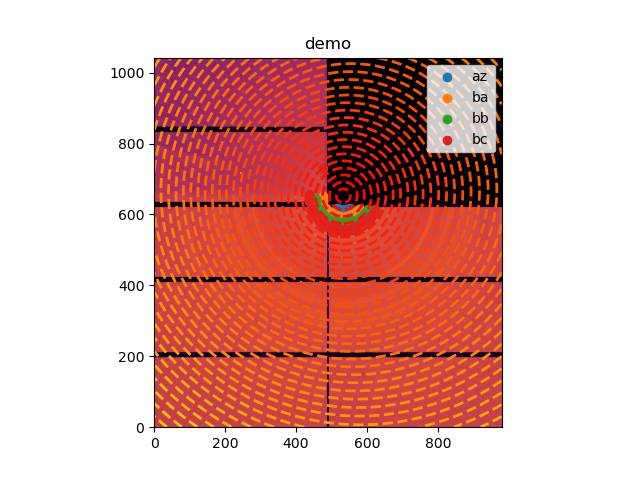

In [60]:
ax = jupyter.display(sg=sg)

In [61]:
#save to .poni file for use in pygix
sg.geometry_refinement.save(calib_path + 'keith_1theta_AgBh_jupyter.poni')

In [62]:
#azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)
ai = pyFAI.load(calib_path + 'keith_1theta_AgBh_jupyter.poni')

In [63]:
res1 = ai.integrate1d(img, 1000) #circular integration
res2 = ai.integrate2d(img, 1000) #makes caked 2d image (q vs chi)


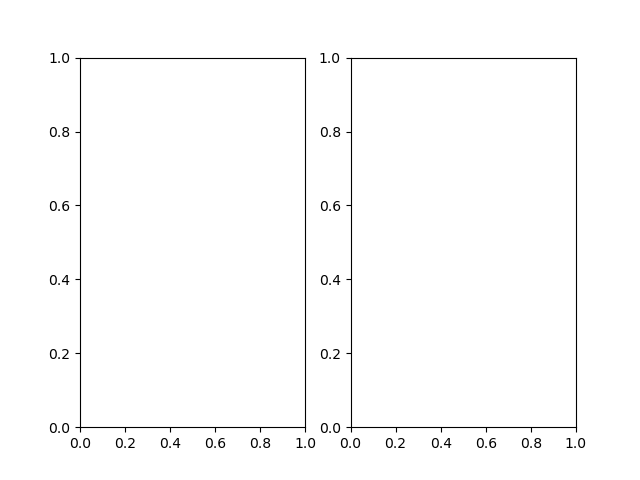

In [64]:
#initialize some interactive plots
from matplotlib.pyplot import subplots
fig, (ax1, ax2) = subplots(1, 2)



In [66]:
#populating plots with pyFAI.gui jupyter command
jupyter.plot1d(res1, ax=ax1, calibrant=AgBh)
jupyter.plot2d(res2, ax=ax2, calibrant=AgBh)
ax2.set_title('2D cake')
plt.tight_layout()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 9.760000e-11m
SampleDetDist= 1.970345e-01m	PONI= 9.649802e-02, 6.224646e-02m	rot1=-0.148923  rot2= 0.079228  rot3= 0.000000 rad
DirectBeamDist= 199.867mm	Center: x=533.769, y=653.003 pix	Tilt=9.657 deg  tiltPlanRotation= 28.151 deg


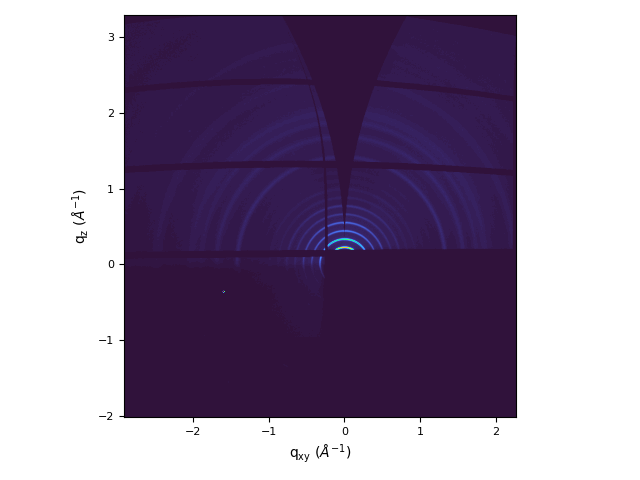

In [67]:
#declare sample path and open sample data
sam_path = '/Users/Thomas2/Desktop/Keith_data/'
sam = fabio.open(sam_path + 'AgBh_GIWAXS_5000RPM_TopOn_780.2s_x0.249_th1.000_2.00s_632051_maxs.tiff').data

#load calibration.poni file into pygix along with experimental parameters
pg = pygix.Transform()
pg.load(calib_path + 'keith_1theta_AgBh_jupyter.poni')
pg.sample_orientation = 3
pg.incident_angle = 1.0
print(pg)

#Convert to q-space
sam_rec, qxy, qz = pg.transform_reciprocal(sam, 
                                           method = 'bbox', #for some reason splitpix doesnt work?
                                           correctSolidAngle=True,
                                           unit='A',)

#plotting both full qmap and zoomed in qmap
fig, ax1 = subplots(1)
ax1.imshow(sam_rec,
           norm=matplotlib.colors.Normalize(vmin=0,vmax=9000),
           cmap='turbo',
           extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
           origin = 'lower')
# ax1.set_ylim(-0.75, 3)
ax1.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)')
ax1.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)')
ax1.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()

0.0010337626752045005 3.048566129178072 -1.2527284051237122 3.0694802810926243


[1.03376268e-03 3.10128803e-03 5.16881338e-03 ... 3.04443108e+00
 3.04649860e+00 3.04856613e+00]
